In [63]:
from matplotlib import pyplot as plt
import pandas as pd
import expected_max_performance
import numpy as np

In [117]:
data = {
    "DilatedCNN-3L(CH)": "../stats/seq_ch_conv_3lv.yaml-2020-05-15--13-36.30.csv",
    "DilatedCNN-3L(CH+SY)": "../stats/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30.csv",
    "UniLSTM(CH)": "../stats/seq_ch_lstm_uni.yaml-2020-05-16--10-14.30.csv",
    "BiLSTM(CH)": "../stats/seq_ch_lstm_bi.yaml-2020-05-16--10-13.30.csv",
    "BiLSTM(CH+SY)": "../stats/seq_sy_ch_lstm_bi.yaml-2020-05-16--17-57.30.csv",
}

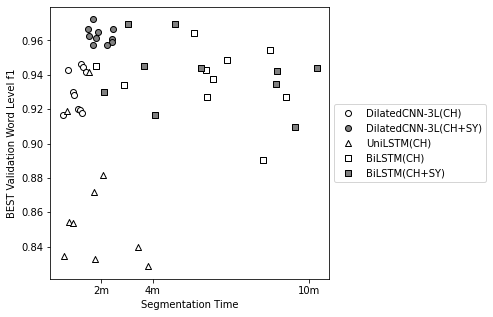

In [119]:
def marker(k):
    if "CNN" in k:
        return "o"
    elif "UniLSTM" in k:
        return "^"
    elif "BiLSTM" in k:
        return "s"
    
def plot_hyperopt(families, n=10):
    plt.figure(figsize=(5, 5))
    # draw max line
    for k in families:
        df = pd.read_csv(data[k]).sort_values(by="best-val:word_level:f1", ascending=False)[:n]
        plt.scatter(
            df["best-val:time_took"] / 60 , df["best-val:word_level:f1"],
            label=k,
            marker=marker(k),
            edgecolor="black",
            facecolor="gray" if "SY" in k else "white"
        )

    plt.ylabel("BEST Validation Word Level f1")
    plt.xlabel("Segmentation Time")
    plt.xticks([2, 4, 10], ["2m", "4m", "10m"])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plot_hyperopt(["DilatedCNN-3L(CH)", "DilatedCNN-3L(CH+SY)", "UniLSTM(CH)", "BiLSTM(CH)", "BiLSTM(CH+SY)"], n=10)

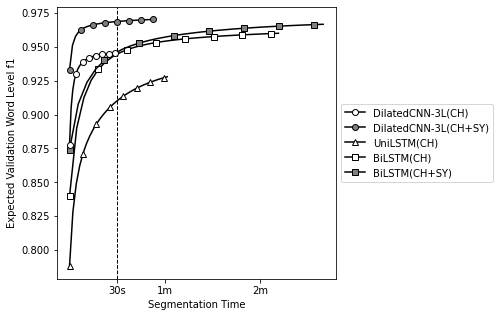

In [120]:
def plot_expected_perf(families):
    plt.figure(figsize=(5, 5))
    plt.axvline(30, ls="--", zorder=0, color="black", lw=1)
    for k in families:
        df = pd.read_csv(data[k])
        exp_perf = expected_max_performance.samplemax(df["best-val:word_level:f1"])
        
        avg_seg_time = (df["best-val:time_took"] / (60)).mean()
        x = np.arange(0, df.shape[0]) * avg_seg_time
        plt.plot(
            x, 
            exp_perf["mean"],
            marker=marker(k), 
            label=k,
            markevery=4,
            markerfacecolor="gray" if "SY" in k else "white",
            color="black",
            zorder=1 if "CNN" in k else 0
        )
#         plt.scatter(
#             df["training_took"] / 60, df["best-val:word_level:f1"],
#             label=k,
#             marker=maker(k),
#             edgecolor="black",
#             facecolor="gray" if "SY" in k else "white"
#         )

    plt.ylabel("Expected Validation Word Level f1")
    plt.xlabel("Segmentation Time")
    plt.xticks([30, 60, 120], ["30s", "1m", "2m"])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plot_expected_perf(["DilatedCNN-3L(CH)", "DilatedCNN-3L(CH+SY)", "UniLSTM(CH)", "BiLSTM(CH)", "BiLSTM(CH+SY)"])